## **LIBRARY IMPORTS**

In [38]:
# Import Libraries
import cudf
import os
import joblib
import pywt
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wfdb  # For reading MIT-BIH data
import keras_tuner as kt
import seaborn as sns
import tensorflow as tf

# Scikit-learn and Imbalanced-learn imports
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    auc,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score
)
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline
from scipy.stats import entropy
from collections import Counter
from scipy.signal import find_peaks, resample, butter, filtfilt, iirnotch, spectrogram

# Model imports
from sklearn.svm import SVC
from imblearn.ensemble import BalancedRandomForestClassifier
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, MaxPooling1D, Dropout, Add, GlobalAveragePooling1D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from cuml.ensemble import RandomForestClassifier
from scikeras.wrappers import KerasClassifier
from sklearn.utils.class_weight import compute_class_weight

# Additional setups
# Checking cUML
print(cudf.Series([1, 2, 3]))

# Setting TensorFlow flags
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Checking GPU
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print(f"TensorFlow has detected {len(gpu_devices)} GPU(s):")
    for device in gpu_devices:
        print(f"- {device}")
else:
    print("TensorFlow did not detect any GPUs. Training will run on the CPU.")


0    1
1    2
2    3
dtype: int64
TensorFlow has detected 1 GPU(s):
- PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## **DATA PREPARATION**

### DATA PREPARATION FUNCTIONS
There are 3 types of functions:
1. Labels and windowed features of the RR intervals
2. Data preparation of MIT-BIH dataset as training and validation set
3. Data preparation of additional ECG data with a format of .bin as the final testing set

In [39]:
# 1. LABELS & ADDITIONAL FUNCTIONS
label_map = {
    'N': 0, '.': 0, 'L': 0, 'R': 0, 'e': 0, 'j': 0,  # Class 0: Normal Beats (N)
    'V': 1, 'E': 1,                                  # Class 1: Ventricular Ectopic (VEB)
    'S': 2, 'A': 2, 'a': 2, 'J': 2,                  # Class 2: Supraventricular Ectopic (SVEB)
    'F': 3                                           # Class 3: Fusion Beat (F)
}

# Helper function for resampling signals to a new length
def resample_data(X, original_len, new_len):
    """Resamples all windows in X from original_len to new_len."""
    # Ensure X is 3D (num_samples, time_steps, channels)
    if X.ndim != 3:
        raise ValueError("Input array X must be 3-dimensional.")
    
    # Remove the channel dimension for resampling
    X_reshaped = X.squeeze(axis=-1)
    
    # Resample each signal window
    resampled_X = np.apply_along_axis(
        lambda row: resample(row, new_len),
        axis=1,
        arr=X_reshaped
    )
    
    # Add the channel dimension back
    return np.expand_dims(resampled_X, axis=-1)

# Extract features of wavelet for 1D-CNN
def extract_wavelet_features(window, wavelet='db4', level=4):
    """
    Extracts statistical and entropy-based features from the wavelet coefficients of an ECG window.
    
    Args:
        window (np.ndarray): A 1D numpy array representing a single ECG beat window.
        wavelet (str): The type of wavelet to use.
        level (int): The level of wavelet decomposition.
        
    Returns:
        np.ndarray: A 1D numpy array containing the extracted features.
    """
    # Decompose the signal
    coeffs = pywt.wavedec(window, wavelet, level=level)
    
    features = []
    for c in coeffs:
        # Basic statistical features
        features.append(np.mean(c))
        features.append(np.std(c))
        features.append(np.var(c))
        
        # Energy of the coefficients
        features.append(np.sum(np.square(c)))
        
        # Shannon Entropy of the coefficients
        # We use the squared coeffs to represent energy distribution for entropy calculation
        # Adding a small epsilon to avoid log(0)
        features.append(entropy(np.square(c) + 1e-9))
        
    return np.array(features)

In [40]:
# 2. DATA LOADING UTILITY OF MIT-BIH DATA
# This function efficiently loads the specified records and their annotations.
def load_mitbih_records(db_path, record_names):
    """
    Loads raw ECG signals and annotations for specified records from both leads.

    Args:
        db_path (str): The path to the database directory.
        record_names (list): A list of record names as strings.

    Returns:
        A tuple containing three lists: (signals_leadA, signals_leadB, annotations).
        - signals_leadA: A list of raw ECG signal arrays for channel 0.
        - signals_leadB: A list of raw ECG signal arrays for channel 1.
        - annotations: A list of wfdb Annotation objects.
    """
    signals_leadA = []
    signals_leadB = []
    all_annotations = []
    print(f"Loading records: {', '.join(record_names)}...")
    for rec_name in record_names:
        record_path = f'{db_path}/{rec_name}'
        try:
            # Read both channels (0 and 1)
            record = wfdb.rdrecord(record_path, channels=[0, 1])
            signals_leadA.append(record.p_signal[:, 0].flatten())
            signals_leadB.append(record.p_signal[:, 1].flatten())
            
            # Annotations are the same for both leads
            annotation = wfdb.rdann(record_path, 'atr')
            all_annotations.append(annotation)
        except Exception as e:
            print(f"Error processing record {rec_name}: {e}")
    print("Loading complete.")
    return signals_leadA, signals_leadB, all_annotations

# A function to extract raw signal windows (beats) for model training.
def prepare_raw_data(signals, annotations, window_size, fs=360):
    """
    Prepares data by extracting fixed-size raw ECG signal windows
    centered around each annotated R-peak.

    Args:
        signals (list): List of raw ECG signal arrays.
        annotations (list): List of wfdb Annotation objects.
        window_size (int): The total number of samples in each window (e.g., 288).
        fs (int): The sampling frequency of the signals (default is 360 for MIT-BIH).

    Returns:
        A tuple (X, y) where:
        - X is a numpy array of ECG signal windows, ready for a CNN.
        - y is a numpy array of corresponding integer labels.
    """
    # A common practice is to place the R-peak off-center (e.g., at 1/3)
    # for better feature extraction by the model.
    samples_before = window_size // 3
    samples_after = window_size - samples_before

    all_windows = []
    all_labels = []

    # Process each signal and its corresponding annotations
    for i, signal in enumerate(signals):
        ann = annotations[i]
        r_peaks = ann.sample
        symbols = ann.symbol

        # Verify the record's sampling frequency
        if ann.fs != fs:
            print(f"Warning: Record {ann.record_name} has fs={ann.fs}, but expected fs={fs}. Skipping.")
            continue

        # Extract a window for each valid R-peak annotation
        for j, r_peak_loc in enumerate(r_peaks):
            symbol = symbols[j]
            # Classify only the beats defined in our label_map
            if symbol in label_map:
                start = r_peak_loc - samples_before
                end = r_peak_loc + samples_after

                # Ensure the window is fully within the signal's bounds
                if start >= 0 and end < len(signal):
                    window = signal[start:end]
                    label = label_map[symbol]
                    all_windows.append(window)
                    all_labels.append(label)

    # Convert lists to numpy arrays
    X = np.array(all_windows)
    y = np.array(all_labels)

    # Add a "channel" dimension for compatibility with deep learning models (e.g., CNNs)
    # The shape becomes (number_of_beats, window_size, 1)
    X = np.expand_dims(X, axis=-1)

    return X, y

# Wavelet data from MIT-BIH
def prepare_wavelet_data(signals, annotations, window_size, fs=360, wavelet='db4', level=4):
    """
    Prepares data by extracting wavelet-based features from ECG signal windows
    centered around each annotated R-peak.

    Args:
        signals (list): List of raw ECG signal arrays.
        annotations (list): List of wfdb Annotation objects.
        window_size (int): The total number of samples in each window.
        fs (int): The sampling frequency of the signals.
        wavelet (str): The type of wavelet to use for feature extraction.
        level (int): The level of wavelet decomposition.

    Returns:
        A tuple (X, y) where:
        - X is a 2D numpy array of wavelet features (num_beats, num_features).
        - y is a 1D numpy array of corresponding integer labels.
    """
    samples_before = window_size // 3
    samples_after = window_size - samples_before

    all_feature_vectors = []
    all_labels = []

    for i, signal in enumerate(signals):
        ann = annotations[i]
        r_peaks = ann.sample
        symbols = ann.symbol

        if ann.fs!= fs:
            print(f"Warning: Record {ann.record_name} has fs={ann.fs}, but expected fs={fs}. Skipping.")
            continue

        for j, r_peak_loc in enumerate(r_peaks):
            symbol = symbols[j]
            if symbol in label_map:
                start = r_peak_loc - samples_before
                end = r_peak_loc + samples_after

                if start >= 0 and end < len(signal):
                    window = signal[start:end]
                    label = label_map[symbol]
                    
                    # Extract features from the window
                    features = extract_wavelet_features(window, wavelet=wavelet, level=level)
                    
                    all_feature_vectors.append(features)
                    all_labels.append(label)

    X = np.array(all_feature_vectors)
    y = np.array(all_labels)

    print(f"Successfully created feature matrix with shape: {X.shape}")
    return X, y

In [41]:
# 3. DATA LOADING FOR .bin FILES
# A function to load ECG data
def load_ecg_from_bin(file_path, dtype=np.int16):
    """
    Loading raw ECG signals from binary files.

    Args:
        file_path (str): Path to the .bin file.
        dtype (numpy.dtype): Data type of the signal in the .bin file.

    Return:
        numpy.ndarray: ECG signals as a numpy array.
    """
    try:
        signal = np.fromfile(file_path, dtype=dtype)
        print(f"Completed reading {len(signal)} samples from {file_path}")
        return signal
    except IOError as e:
        print(f"An error has occurred while reading: {e}")
        return None

# A function to detect R-peaks for labelling
def detect_r_peaks(signal, fs):
    """
    Detecting R-peaks from the ECG signal. This serves as our substitute
    for reading an annotation file.

    Args:
        signal (numpy.ndarray): Raw ECG signal in a numpy array.
        fs (int): Sampling frequency of the ECG signal.

    Return:
        numpy.ndarray: An array of indices of the detected R-peaks.
    """
    print("\n--- Step 1: Detecting R-Peaks to locate heartbeats ---")
    height_threshold = np.max(signal) * 0.6
    distance_threshold = fs * 0.4
    r_peaks, _ = find_peaks(signal, height=height_threshold, distance=distance_threshold)
    print(f"Detected {len(r_peaks)} R-peaks.")
    return r_peaks

# A function to prepare raw ECG data with its R-peaks
def prepare_raw_data_from_bin(signal, r_peaks, window_size, record_label):
    """
    Prepares data by extracting fixed-size raw ECG signal windows
    centered around each detected R-peak from a .bin file.

    Args:
        signal (numpy.ndarray): The raw ECG signal array.
        r_peaks (numpy.ndarray): The indices of the detected R-peaks.
        window_size (int): The total number of samples in each window.
        record_label (int): The integer label to apply to all windows from this record.

    Returns:
        A tuple (X, y) where:
        - X is a numpy array of ECG signal windows, ready for a CNN.
        - y is a numpy array of corresponding integer labels.
    """
    print(f"\n--- Step 2: Extracting raw signal windows ---")
    samples_before = window_size // 3
    samples_after = window_size - samples_before

    all_windows = []
    all_labels = []

    for r_peak_loc in r_peaks:
        start = r_peak_loc - samples_before
        end = r_peak_loc + samples_after

        # Ensure the window is fully within the signal's bounds
        if start >= 0 and end < len(signal):
            window = signal[start:end]
            all_windows.append(window)
            all_labels.append(record_label)

    # Convert lists to numpy arrays
    X = np.array(all_windows)
    y = np.array(all_labels)

    # Add a "channel" dimension for compatibility with deep learning models (e.g., CNNs)
    # The shape becomes (number_of_beats, window_size, 1)
    X = np.expand_dims(X, axis=-1)

    print(f"Successfully created {len(X)} windows of size {window_size}.")
    print(f"Final data shape (X): {X.shape}")
    print(f"Final labels shape (y): {y.shape}")

    return X, y

# Wavelet data from raw ECG data with format of .bin
def prepare_wavelet_data_from_bin(signal, r_peaks, window_size, record_label, wavelet='db4', level=4):
    """
    Prepares data by extracting wavelet features from windows around R-peaks from a.bin file.

    Args:
        signal (numpy.ndarray): The raw ECG signal array.
        r_peaks (numpy.ndarray): The indices of the detected R-peaks.
        window_size (int): The total number of samples in each window.
        record_label (int): The integer label to apply to all windows.
        wavelet (str): The type of wavelet to use for feature extraction.
        level (int): The level of wavelet decomposition.

    Returns:
        A tuple (X, y) where:
        - X is a 2D numpy array of wavelet features.
        - y is a 1D numpy array of corresponding integer labels.
    """
    print(f"\n--- Step 2: Extracting wavelet features from signal windows ---")
    samples_before = window_size // 3
    samples_after = window_size - samples_before

    all_feature_vectors = []
    all_labels = []

    for r_peak_loc in r_peaks:
        start = r_peak_loc - samples_before
        end = r_peak_loc + samples_after

        if start >= 0 and end < len(signal):
            window = signal[start:end]
            
            # Extract features from the window
            features = extract_wavelet_features(window, wavelet=wavelet, level=level)
            
            all_feature_vectors.append(features)
            all_labels.append(record_label)

    X = np.array(all_feature_vectors)
    y = np.array(all_labels)

    print(f"Successfully created {len(X)} feature vectors.")
    print(f"Final feature matrix shape (X): {X.shape}")
    print(f"Final labels shape (y): {y.shape}")

    return X, y

# A function to visualize the data
def plot_beat_windows(X, y, n=5):
    """
    Plots a few sample beat windows.

    Args:
        X (numpy.ndarray): The data windows.
        y (numpy.ndarray): The labels.
        n (int): Number of samples to plot.
    """
    plt.figure(figsize=(15, 10))
    for i in range(n):
        plt.subplot(n, 1, i + 1)
        plt.plot(X[i].flatten()) # flatten to remove the channel dimension for plotting
        plt.title(f"Sample Beat Window {i+1} - Label: {y[i]}")
        plt.ylabel("Amplitude")
    plt.xlabel("Sample Number within Window")
    plt.tight_layout()
    plt.show()

### DATA PREPARATION EXECUTION
1. Reading all ECG datasets
2. Divide all datasets into training dataset and testing dataset
3. Standard scaling and combining datasets
4. Splitting training dataset into training split and validation split then applying SMOTE algorithm into the training split
5. Preparing all the datasets for each machine learning model
The feature extraction of this data is transforming the data into wavelet data. Beforehand, the data was transformed into RR-intervals only data, but the data provided is limited to its RR-intervals and it didn't represent the heartbeat morphology of the data. Then, it was transformed into raw ECG data which is better than before, but the data was costly and thus needed further transformation. Lastly, it is transformed into wavelet data

In [42]:
    # --- Configuration Section ---
    DB_PATH_MIT = '../data/raw/MIT-BIH/mit-bih-arrhythmia-database-1.0.0/mit-bih-arrhythmia-database-1.0.0/'
    FS_MIT = 360
    WINDOW_SIZE_MIT = 288  # 800ms window -> 0.8s * 360Hz

    # Wavelet Feature Configuration
    WAVELET_TYPE = 'db4'
    WAVELET_LEVEL = 4

    # Split MIT-BIH records into training and testing sets to prevent patient data leakage
    RECORDS_TRAIN = ['101', '106', '108', '109', '112', '114', '115', '116', '118', '119',
                     '122', '124', '201', '203', '205', '207', '208', '209', '215', '220',
                     '223', '230'] # DS1
    RECORDS_TEST = ['100', '103', '105', '111', '113', '117', '121', '123', '200', '202',
                    '210', '212', '213', '214', '219', '221', '222', '228', '231', '232',
                    '233', '234'] # DS2

    FS_CUSTOM = 500
    WINDOW_SIZE_CUSTOM = 400  # 800ms window -> 0.8s * 500Hz
    custom_file_paths = {
        'Arrhythmia': '../data/raw/Arrhythmia/ECG_WAVE.bin',
        'Normal': '../data/raw/Normal/ecg_normal.bin' 
    }
    custom_file_labels = {'Arrhythmia': 2, 'Normal': 0} # SVEB and Normal

    # ===================================================================
    # Data Preparation Pipeline (Multi-Lead Wavelet Features)
    # ===================================================================

    # --- [Step 1] Extract & Combine Multi-Lead Features from MIT-BIH ---
    print("--- [Step 1] Processing Multi-Lead MIT-BIH Data ---")

    # Process Training Set (DS1)
    print("\nProcessing MIT-BIH Training set (DS1)...")
    train_signals_A, train_signals_B, train_anns = load_mitbih_records(DB_PATH_MIT, RECORDS_TRAIN)
    X_train_A, y_train_A = prepare_wavelet_data(train_signals_A, train_anns, WINDOW_SIZE_MIT, fs=FS_MIT)
    X_train_B, _ = prepare_wavelet_data(train_signals_B, train_anns, WINDOW_SIZE_MIT, fs=FS_MIT)
    X_train_mit = np.hstack((X_train_A, X_train_B))
    y_train_mit = y_train_A
    print(f"Combined MIT-BIH Training feature matrix shape: {X_train_mit.shape}")

    # Process Testing Set (DS2)
    print("\nProcessing MIT-BIH Testing set (DS2)...")
    test_signals_A, test_signals_B, test_anns = load_mitbih_records(DB_PATH_MIT, RECORDS_TEST)
    X_test_A, y_test_A = prepare_wavelet_data(test_signals_A, test_anns, WINDOW_SIZE_MIT, fs=FS_MIT)
    X_test_B, _ = prepare_wavelet_data(test_signals_B, test_anns, WINDOW_SIZE_MIT, fs=FS_MIT)
    X_test_mitbih = np.hstack((X_test_A, X_test_B))
    y_test_mitbih = y_test_A
    print(f"Combined MIT-BIH Testing feature matrix shape: {X_test_mitbih.shape}")

    # --- [Step 2] Process Single-Lead Custom Data ---
    print("\n--- [Step 2] Processing Single-Lead Custom Data ---")
    X_test_custom_list, y_test_custom_list = [], []
    for name, path in custom_file_paths.items():
        label = custom_file_labels[name]
        signal = load_ecg_from_bin(path)
        if signal is not None:
            r_peaks = detect_r_peaks(signal, fs=FS_CUSTOM)
            X_single, y_single = prepare_wavelet_data_from_bin(
                signal, r_peaks, WINDOW_SIZE_CUSTOM, label, wavelet=WAVELET_TYPE, level=WAVELET_LEVEL
            )
            # Duplicate the single-lead features to match the two-lead format
            X_single_doubled = np.hstack((X_single, X_single))
            X_test_custom_list.append(X_single_doubled)
            y_test_custom_list.append(y_single)
            
    X_test_custom = np.vstack(X_test_custom_list)
    y_test_custom = np.concatenate(y_test_custom_list)
    print(f"Combined Custom Testing feature matrix shape: {X_test_custom.shape}")

    # --- [Step 3] Finalize Datasets and Scale ---
    print("\n--- [Step 3] Scaling and Finalizing Data ---")
    X_train = X_train_mit
    y_train = y_train_mit
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    print("Scaler trained on training data.")
    
    X_test_mitbih_scaled = scaler.transform(X_test_mitbih)
    X_test_custom_scaled = scaler.transform(X_test_custom)
    
    X_test_final = np.concatenate((X_test_mitbih_scaled, X_test_custom_scaled), axis=0)
    y_test_final = np.concatenate((y_test_mitbih, y_test_custom), axis=0)
    print(f"Final training data shape: {X_train_scaled.shape}, {y_train.shape}")
    print(f"Final testing data shape: {X_test_final.shape}, {y_test_final.shape}")

    # --- [Step 4] Splitting & Hybrid Sampling ---
    print("\n--- [Step 4] Finalizing Training Data (Split & Hybrid Sample) ---")
    output_dim = len(np.unique(np.concatenate((y_train, y_test_final))))
    
    X_train_fold, X_val, y_train_fold, y_val = train_test_split(
        X_train_scaled, y_train, test_size=0.2, random_state=42, stratify=y_train
    )

    print("Applying HYBRID SAMPLING (SMOTEENN)...")
    print("Class distribution before sampling:", Counter(y_train_fold))
    sampler = SMOTEENN(random_state=42)
    X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_fold, y_train_fold)
    print("Class distribution after sampling:", Counter(y_train_resampled))

    # --- [Step 5] Final Data Preparation for Models ---
    print("\n--- [Step 5] Preparing Final Datasets for Models ---")
    
    y_train_encoded = to_categorical(y_train_resampled, num_classes=output_dim)
    y_val_encoded = to_categorical(y_val, num_classes=output_dim)
    y_test_final_encoded = to_categorical(y_test_final, num_classes=output_dim)

    # Data for MLP
    X_train_mlp, y_train_mlp = X_train_resampled, y_train_encoded
    X_val_mlp, y_val_mlp = X_val, y_val_encoded
    X_test_mlp, y_test_mlp = X_test_final, y_test_final_encoded

    # Data for 1D-CNN
    X_train_cnn = X_train_mlp.reshape((X_train_mlp.shape[0], X_train_mlp.shape[1], 1))
    X_val_cnn = X_val_mlp.reshape((X_val_mlp.shape[0], X_val_mlp.shape[1], 1))
    X_test_cnn = X_test_mlp.reshape((X_test_mlp.shape[0], X_test_mlp.shape[1], 1))
    y_train_cnn, y_val_cnn, y_test_cnn = y_train_mlp, y_val_mlp, y_test_mlp

    # Data for RandomForest
    X_train_rf, y_train_rf = X_train_resampled, y_train_resampled
    X_val_rf, y_val_rf = X_val, y_val
    X_test_rf, y_test_rf = X_test_final, y_test_final

    print("\n" + "="*60)
    print("✅ MULTI-LEAD WAVELET DATA PREPARATION COMPLETE ✅")
    print("="*60)

--- [Step 1] Processing Multi-Lead MIT-BIH Data ---

Processing MIT-BIH Training set (DS1)...
Loading records: 101, 106, 108, 109, 112, 114, 115, 116, 118, 119, 122, 124, 201, 203, 205, 207, 208, 209, 215, 220, 223, 230...
Loading complete.
Successfully created feature matrix with shape: (50993, 25)
Successfully created feature matrix with shape: (50993, 25)
Combined MIT-BIH Training feature matrix shape: (50993, 50)

Processing MIT-BIH Testing set (DS2)...
Loading records: 100, 103, 105, 111, 113, 117, 121, 123, 200, 202, 210, 212, 213, 214, 219, 221, 222, 228, 231, 232, 233, 234...
Loading complete.
Successfully created feature matrix with shape: (49683, 25)
Successfully created feature matrix with shape: (49683, 25)
Combined MIT-BIH Testing feature matrix shape: (49683, 50)

--- [Step 2] Processing Single-Lead Custom Data ---
Completed reading 2380000 samples from ../data/raw/Arrhythmia/ECG_WAVE.bin

--- Step 1: Detecting R-Peaks to locate heartbeats ---
Detected 137 R-peaks.

--- S

## **MACHINE LEARNING MODEL TRAINING & SAVING**

### MACHINE LEARNING MODEL FUNCTIONS
There are 3 models that will be trained:
1. MLP Model (TA242501010)
2. 1D-CNN
3. BalancedRandomForest

There is also an additional function in order to do automatic hyperparameter tuning, but the function is only made for the MLP model.

In [43]:
# Function to build the MLP model for automatic hyperparameter tuning
def build_model(hp):
    """Function that builds a Keras model and defines the hyperparameters to be tuned."""
    model = Sequential()

    # Tune the number of units in the first hidden layer
    hp_units_1 = hp.Int('units_1', min_value=32, max_value=256, step=32)
    model.add(Dense(units=hp_units_1, activation='relu', input_shape=(X_train.shape[1],)))

    # Tune the dropout rate
    hp_dropout_1 = hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)
    model.add(Dropout(rate=hp_dropout_1))

    # Tune the number of units in the second hidden layer
    hp_units_2 = hp.Int('units_2', min_value=32, max_value=256, step=32)
    model.add(Dense(units=hp_units_2, activation='relu'))

    # Tune the dropout rate
    hp_dropout_2 = hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)
    model.add(Dropout(hp_dropout_2))
    model.add(Dense(output_dim, activation='softmax'))

    # Tune the learning rate for the Adam optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer=Adam(learning_rate=hp_learning_rate),
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc_roc'),
            tf.keras.metrics.AUC(name='auc_pr', curve='PR'),
            tf.keras.metrics.F1Score(average='weighted', name='f1_score')
        ]
    )
    return model

# Function to create the MLP model for cross-validation
def create_mlp_model(input_dim, output_dim):
    """Creates and compiles a Keras MLP model."""
    model = Sequential([
        # Hyperparameters tuning
        Dense(512, input_dim=input_dim, activation='relu'),
        Dropout(0.1),
        Dense(512, activation='relu'),
        Dropout(0.4),
        Dense(output_dim, activation='softmax') # Softmax for multi-class classification
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy', # Suitable for one-hot labels
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.F1Score(average='weighted', name='f1_score'),
            tf.keras.metrics.SpecificityAtSensitivity(0.9, name='specificity')
        ]
    )
    return model
# Function to create the 1D-CNN model
def create_cnn_model(input_shape, output_dim):
    """Creates and compiles a Keras 1D-CNN model."""
    # Input shape for CNN must be 3D: (samples, steps, features)
    # Example: (10000, 187, 1)

    model = Sequential([
        Conv1D(filters=512, kernel_size=6, activation='relu', # Reduced filters
               input_shape=input_shape),
        Dropout(0.1),
        MaxPooling1D(pool_size=2),

        Conv1D(filters=512, kernel_size=3, activation='relu'), # Reduced filters
        Dropout(0.2),
        MaxPooling1D(pool_size=2),

        Flatten(), # Now flattens a much smaller tensor

        Dense(512, activation='relu'), # Reduced dense units
        Dropout(0.4),

        Dense(output_dim, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.F1Score(average='weighted', name='f1_score'),
            tf.keras.metrics.SpecificityAtSensitivity(0.9, name='specificity')
        ]
    )
    return model

def create_resnet_model(input_shape, output_dim, hp=None):
    """
    Creates and compiles an optimized 1D-CNN model.
    If 'hp' is provided, it builds a tunable model for KerasTuner.
    Otherwise, it builds a model with default hyperparameters.
    """
    # Define a default hyperparameter object if none is passed
    if hp is None:
        hp = kt.HyperParameters()
        # Set default values for when not tuning
        hp.values['initial_filters'] = 384
        hp.values['res_block_1_filters'] = 384
        hp.values['res_block_2_filters'] = 384
        hp.values['kernel_size_initial'] = 7
        hp.values['kernel_size_res'] = 5
        hp.values['dropout_1'] = 0.1
        hp.values['dropout_2'] = 0.3
        hp.values['dense_units'] = 512
        hp.values['dense_dropout'] = 0.4
        hp.values['learning_rate'] = 0.0001

    def residual_block(x, filters, kernel_size):
        y = Conv1D(filters=filters, kernel_size=kernel_size, padding='same')(x)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)
        y = Conv1D(filters=filters, kernel_size=kernel_size, padding='same')(y)
        y = BatchNormalization()(y)
        shortcut = Conv1D(filters=filters, kernel_size=1, padding='same')(x) if x.shape[-1] != filters else x
        res_output = Add()([shortcut, y])
        return Activation('relu')(res_output)

    inputs = Input(shape=input_shape)
    x = Conv1D(filters=hp.values['initial_filters'], kernel_size=hp.values['kernel_size_initial'], padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = residual_block(x, filters=hp.values['res_block_1_filters'], kernel_size=hp.values['kernel_size_res'])
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(hp.values['dropout_1'])(x)
    x = residual_block(x, filters=hp.values['res_block_2_filters'], kernel_size=hp.values['kernel_size_res'])
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(hp.values['dropout_2'])(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(hp.values['dense_units'], activation='relu')(x)
    x = Dropout(hp.values['dense_dropout'])(x)
    outputs = Dense(output_dim, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=Adam(learning_rate=hp.values['learning_rate']),
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            # Note: F1Score might require a different setup in some TF versions.
            # If it causes issues, consider a custom callback to calculate it.
            tf.keras.metrics.F1Score(average='weighted', name='f1_score'),
        ]
    )
    return model

# Function to create the RandomForest model
def create_rf_model():
    """Creates an instance of the GPU-accelerated RandomForestClassifier model using cuML."""
    # Hyperparameters are similar to imblearn's
    # Note: class_weight is not needed as the balancing is built-in.
    return BalancedRandomForestClassifier(
        n_estimators=150, 
        max_depth=20, 
        random_state=42, 
        n_jobs=-1
    )

### MACHINE LEARNING MODEL TRAINING EXECUTION
1. Targeted metrics: Precision, Recall, F1-Score, and Specificity
2. There are 3 executions: multiple models training (1D-CNN, BalancedRandomForest, and MLP), MLP model specific training, and MLP model automatic hyperparameter tuning
3. After training, all models immediately saved and exported into a certain folder

--- Calculating Class Weights for Cost-Sensitive Learning ---
Calculated Weights: {0: np.float64(0.2780625460097609), 1: np.float64(3.364731111844276), 2: np.float64(13.507947019867549), 3: np.float64(30.81117824773414)}


/mnt/c/Users/OSOTNAS/Documents/Kean/Others/KP_Xirka-Darma-Persada/machine-learning/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



==================== TRAINING MODEL: 1D-CNN ====================
Epoch 1/10
4462/4462 ━━━━━━━━━━━━━━━━━━━━ 98s 16ms/step - accuracy: 0.7757 - f1_score: 0.7298 - loss: 0.9913 - precision: 0.7878 - recall: 0.7675 - val_accuracy: 0.2627 - val_f1_score: 0.3359 - val_loss: 3.1029 - val_precision: 0.2621 - val_recall: 0.2521
Epoch 2/10
4462/4462 ━━━━━━━━━━━━━━━━━━━━ 63s 14ms/step - accuracy: 0.8782 - f1_score: 0.8663 - loss: 0.3160 - precision: 0.8830 - recall: 0.8747 - val_accuracy: 0.5985 - val_f1_score: 0.6883 - val_loss: 1.7252 - val_precision: 0.6013 - val_recall: 0.5905
Epoch 3/10
4462/4462 ━━━━━━━━━━━━━━━━━━━━ 61s 14ms/step - accuracy: 0.9121 - f1_score: 0.9069 - loss: 0.2196 - precision: 0.9144 - recall: 0.9101 - val_accuracy: 0.7245 - val_f1_score: 0.8062 - val_loss: 1.1837 - val_precision: 0.7283 - val_recall: 0.7196
Epoch 4/10
4462/4462 ━━━━━━━━━━━━━━━━━━━━ 63s 14ms/step - accuracy: 0.9275 - f1_score: 0.9240 - loss: 0.1703 - precision: 0.9292 - recall: 0.9261 - val_accuracy: 0.76

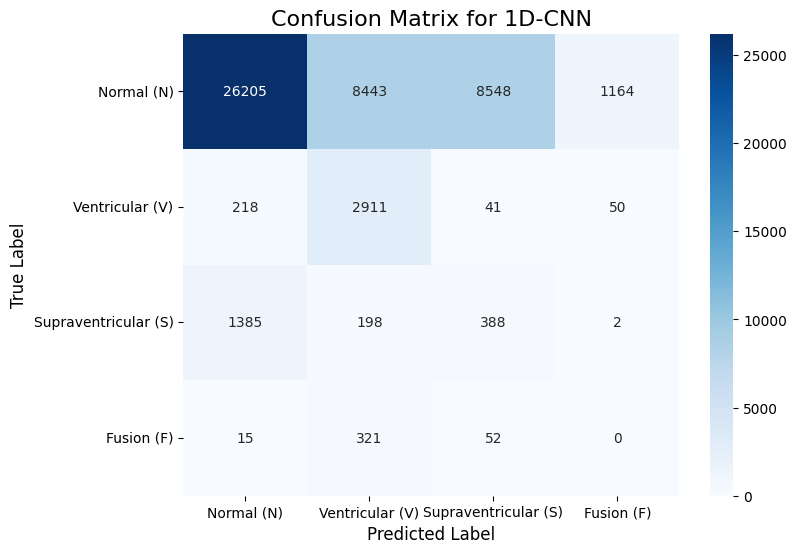

--- Saving model: 1D-CNN ---
INFO:tensorflow:Assets written to: ../models/model_1d-cnn_saved/assets


INFO:tensorflow:Assets written to: ../models/model_1d-cnn_saved/assets


Saved artifact at '../models/model_1d-cnn_saved'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 50), dtype=tf.float32, name='keras_tensor_292')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  134653976352080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134653967139664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134653967140624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134653967139088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134653967141008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134653967140816: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ Model 1D-CNN has been saved on: ../models/model_1d-cnn_saved


~~~~~~~~~~~~~~~ REPORT FOR MODEL: RandomForest ~~~~~~~~~~~~~~~

Classification Report:
                      precision    recall  f1-score   support

          Normal (N)       0.93      0.93      0.93     44360
     Ventric

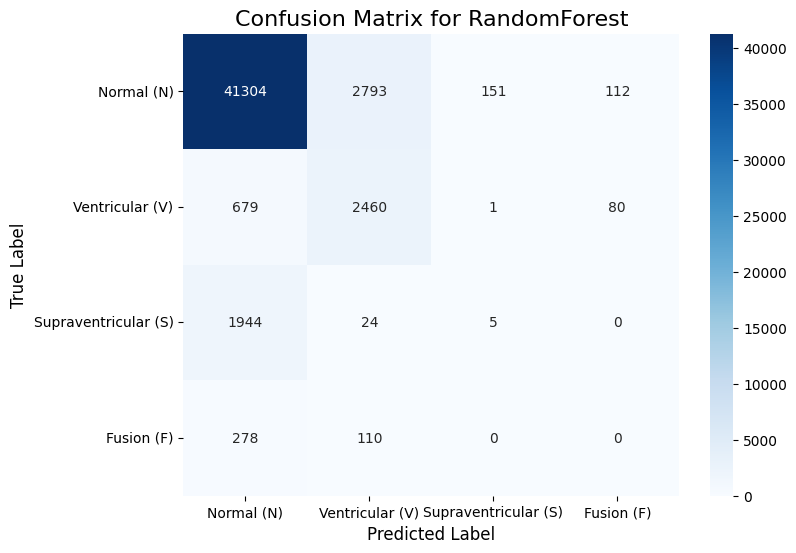

--- Saving model: RandomForest ---
✅ Model RandomForest has been saved on: ../models/model_randomforest.joblib


~~~~~~~~~~~~~~~ REPORT FOR MODEL: MLP ~~~~~~~~~~~~~~~

Classification Report:
                      precision    recall  f1-score   support

          Normal (N)       0.95      0.66      0.77     44360
     Ventricular (V)       0.32      0.88      0.47      3220
Supraventricular (S)       0.08      0.34      0.13      1973
          Fusion (F)       0.01      0.08      0.02       388

            accuracy                           0.65     49941
           macro avg       0.34      0.49      0.35     49941
        weighted avg       0.87      0.65      0.72     49941

Confusion Matrix:


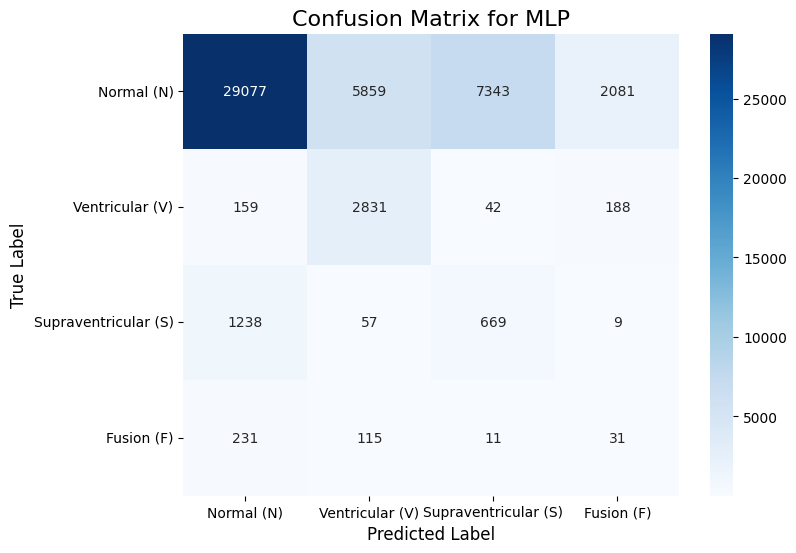

--- Saving model: MLP ---
INFO:tensorflow:Assets written to: ../models/model_mlp_saved/assets


INFO:tensorflow:Assets written to: ../models/model_mlp_saved/assets


Saved artifact at '../models/model_mlp_saved'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 50), dtype=tf.float32, name='keras_tensor_292')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  134653976352080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134653967139664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134653967140624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134653967139088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134653967141008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134653967140816: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ Model MLP has been saved on: ../models/model_mlp_saved


In [44]:
# Training Multiple Models
input_shape_cnn = (X_train_cnn.shape[1], X_train_cnn.shape[2])
input_dim = X_train_mlp.shape[1]

# Saving/exporting models
output_dir = '../models'
os.makedirs(output_dir, exist_ok=True)

# Class Weights
print("--- Calculating Class Weights for Cost-Sensitive Learning ---")
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train_fold),
    y=y_train_fold
)
class_weights_dict = dict(enumerate(class_weights))
print("Calculated Weights:", class_weights_dict)

models = {
    "1D-CNN": create_cnn_model_optimized(input_shape_cnn, output_dim),
    "RandomForest": create_rf_model(),
    "MLP": create_mlp_model(input_dim, output_dim)
}

# Dictionary to store the final results
results = {}

# --- TRAINING AND EVALUATING EACH MODEL ---

for name, model in models.items():
    print(f"\n{'='*20} TRAINING MODEL: {name} {'='*20}")

    # 🧠 Training
    if name == "1D-CNN":
        model.fit(
            X_train_cnn, y_train_cnn,
            epochs=10, # Reduced for quick example
            batch_size=32,
            verbose=1, # Set to 0 to keep output clean
            validation_data=(X_val_cnn, y_val_cnn),
            class_weight=class_weights_dict
        )
    elif name == "MLP":
        model.fit(
            X_train_mlp, y_train_mlp,
            epochs=10, # Reduced for quick example
            batch_size=32,
            verbose=1,
            validation_data=(X_val_mlp, y_val_mlp),
            class_weight=class_weights_dict
        )
    else: # 📊 RandomForest
        model.fit(X_train_rf, y_train_rf)

    # ⚡ Prediction on the Test Set
    print(f"Evaluating model {name}...")
    if name in ["MLP", "1D-CNN"]:
        y_pred_raw = model.predict(X_test_mlp if name == "MLP" else X_test_cnn)
        y_pred = np.argmax(y_pred_raw, axis=1)
    else: # RandomForest
        y_pred = model.predict(X_test_rf)

    # Store prediction results and ground truth for final evaluation
    results[name] = {'y_pred': y_pred, 'y_true': y_test_final}

# --- PRINT ALL RESULTS SIMULTANEOUSLY ---
class_names = ['Normal (N)', 'Ventricular (V)', 'Supraventricular (S)', 'Fusion (F)']

print(f"\n{'='*25} FINAL EVALUATION RESULTS {'='*25}")

for name, result_data in results.items():
    y_true = result_data['y_true']
    y_pred = result_data['y_pred']

    print(f"\n\n{'~'*15} REPORT FOR MODEL: {name} {'~'*15}")
    
    # --- Classification Report ---
    print("\nClassification Report:")
    report = classification_report(y_true, y_pred, target_names=class_names, zero_division=0)
    print(report)

    # --- Confusion Matrix Visualization ---
    print("Confusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix for {name}', fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.show()

    # SAVING MODEL AFTER TRAINING
    print(f"--- Saving model: {name} ---")
    if name in ["1D-CNN", "MLP"]:
        # TensorFlow/Keras models
        model_path = os.path.join(output_dir, f"model_{name.lower()}_saved")
        model.export(model_path) # Saving models
        print(f"✅ Model {name} has been saved on: {model_path}")
    else: #RandomForest/other scikit-learn models
        model_path = os.path.join(output_dir, f"model_{name.lower()}.joblib")
        joblib.dump(model, model_path) # Saving models
        print(f"✅ Model {name} has been saved on: {model_path}")

In [ ]:
# Training MLP Model - TA242501010
# Initialize AI model
model = create_mlp_model(input_dim, output_dim)

# Prepare EarlyStopping callback for F1 score validation
early_stopping_1 = EarlyStopping(monitor='val_f1_score', patience=5, restore_best_weights=True)

# Prepare class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

# Start AI model training
history = model.fit(
    X_train_resampled,
    y_train_resampled_encoded,
    epochs=20,
    batch_size=16,
    validation_data=(X_val_fold, y_val_fold_encoded),
    verbose=1,
    # class_weight=class_weight_dict,
    validation_split=0.2
    # callbacks=[early_stopping_1]
)

# Evaluate on the untouched set
print("Evaluating on the untouched test set...")
X_test_scaled = scaler.transform(X_test)
y_pred_test_raw = model.predict(X_test_scaled)

# Convert predictions back to labels if they are one-hot encoded
if hasattr(y_pred_test_raw, 'shape') and len(y_pred_test_raw.shape) > 1:
      y_pred_test = np.argmax(y_pred_test_raw, axis=1)
else:
      y_pred_test = y_pred_test_raw

class_names = ['Normal (N)', 'Ventricular (V)', 'Supraventricular (S)', 'Fusion (F)', 'Unknown (Q)']

print("\nClassification Report on the Test Set:")
print(classification_report(y_test, y_pred_test, target_names=class_names))

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# Calculate metrics for each class (one-vs-rest)
print("\nAdditional Metrics Report:")
print("="*55)
for i in range(len(class_names)):
    tn = cm.sum() - (cm[i,:].sum() + cm[:,i].sum() - cm[i,i])
    tp = cm[i,i]
    fp = cm[:,i].sum() - cm[i,i]
    fn = cm[i,:].sum() - cm[i,i]

    # Sensitivity (Recall)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    # Specificity
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    # False Positive Rate
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

    print(f"Class: {class_names[i]}")
    print(f"  Sensitivity (Recall): {sensitivity:.4f}")
    print(f"  Specificity         : {specificity:.4f}")
    print(f"  False Positive Rate : {fpr:.4f}")
    print("-"*25)

In [ ]:
# Automatic Hyperparameter Tuning
print("\n--- Starting Automatic Hyperparameter Tuning with KerasTuner ---")

# Calculate class_weight only once
# class_weights = compute_class_weight(
#     'balanced',
#     classes=np.unique(y_train),
#     y=y_train
# )
# class_weight_dict = dict(enumerate(class_weights))

# Defining tuner objectives
multi_objectives = [
    kt.Objective("val_f1_score", direction="max")
    #kt.Objective("val_specificity", direction="max")
    #kt.Objective("val_precision", direction="max")
    #kt.Objective("val_recall", direction="max")
    #kt.Objective("val_auc_roc", direction="max")
    #kt.Objective("val_auc_pr", direction="max")
]
# Initialize Tuner with RandomSearch
tuner = kt.RandomSearch(
    build_model,
    objective=multi_objectives, # Target: maximize validation F1 score
    max_trials=20,              # Total number of hyperparameter combinations to be tried
    executions_per_trial=1,     # Number of models trained per combination (for stability)
    directory='keras_tuner_dir',
    project_name='ecg_classification_0834' # Can change the name to find the latest parameters with the latest code
)

# Prepare EarlyStopping callback for F1 score validation
early_stopping = EarlyStopping(monitor='val_f1_score', patience=5, restore_best_weights=True)

# Run the search
print("\nStarting the search for the best hyperparameters...")
tuner.search(
    X_train_resampled,              # Training data that has been processed with SMOTE
    y_train_resampled_encoded,
    epochs=100,
    validation_data=(X_val_fold, y_val_fold_encoded), # 1. Use validation_data
    # class_weight=class_weight_dict,
    callbacks=[early_stopping],
    verbose=1
)

# Get the best hyperparameters and the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
--- Search Complete ---
Best hyperparameters found:
- Units 1: {best_hps.get('units_1')}
- Dropout 1: {best_hps.get('dropout_1'):.2f}
- Units 2: {best_hps.get('units_2')}
- Dropout 2: {best_hps.get('dropout_2'):.2f}
- Learning Rate: {best_hps.get('learning_rate')}
""")

# --- Final Evaluation on the Test Set ---
print("\n--- Evaluating the Best Model on the Test Set ---")
X_test_scaled = scaler.transform(X_test) # Use the same scaler from training
y_pred_test_raw = best_model.predict(X_test_scaled)
y_pred_test = np.argmax(y_pred_test_raw, axis=1)
class_names = ['Normal (N)', 'Ventricular (V)', 'Supraventricular (S)', 'Fusion (F)', 'Unknown (Q)']

# --- 1. Classification Report ----
print("\nClassification Report on the Test Set:")
print(classification_report(y_test, y_pred_test, target_names=class_names))

# --- 2. Confusion Matrix ---
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# --- 3. Specific Metric Calculation per Class ---
print("\n--- Detailed Performance Metrics per Class ---")
metrics_data = []

for i, class_name in enumerate(class_names):
    # Specificity calculation
    tn = cm.sum() - (cm[i,:].sum() + cm[:,i].sum() - cm[i,i])
    fp = cm[:,i].sum() - cm[i,i]
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    metrics_data.append({
        "Class": class_name,
        "Precision": precision_score(y_test, y_pred_test, average=None)[i],
        "Sensitivity (Recall)": recall_score(y_test, y_pred_test, average=None)[i],
        "F1-Score": f1_score(y_test, y_pred_test, average=None)[i],
        "Specificity": specificity
    })

metrics_df = pd.DataFrame(metrics_data)
print(metrics_df.to_string())


# --- 4. Calculation of AUC-ROC and AUC-PR (One-vs-Rest) ---
y_test_encoded = to_categorical(y_test, num_classes=output_dim)

# Add this line to define y_pred_proba
y_pred_proba = best_model.predict(X_test_scaled)

# AUC-ROC
auc_roc_ovr = roc_auc_score(y_test_encoded, y_pred_proba, multi_class='ovr', average='weighted')
print(f"\nAUC-ROC (One-vs-Rest, Weighted): {auc_roc_ovr:.4f}")

# AUC-PR
# Calculate for each class and average
precision_curves = dict()
recall_curves = dict()
auc_pr_scores = []
for i in range(output_dim):
    precision_curves[i], recall_curves[i], _ = precision_recall_curve(y_test_encoded[:, i], y_pred_proba[:, i])
    auc_pr_scores.append(auc(recall_curves[i], precision_curves[i]))

# Weighted average for AUC-PR
support = np.bincount(y_test)
avg_auc_pr = np.average(auc_pr_scores, weights=support)
print(f"AUC-PR (One-vs-Rest, Weighted): {avg_auc_pr:.4f}")

# Plotting PR Curves for each class
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(class_names):
    plt.plot(recall_curves[i], precision_curves[i], lw=2, label=f'{class_name} (AUC-PR = {auc_pr_scores[i]:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve per Class")
plt.legend(loc="best")
plt.grid(True)
plt.show()

## **SAVING MACHINE LEARNING MODELS AFTER TRAINING**

In [ ]:
# Cukup panggil model.save() dan berikan nama folder tujuan.
CNN_folder = '../models/1D-CNN'
model_mlp.save(nama_folder_model)

print(f"\nModel MLP telah disimpan dalam folder: '{nama_folder_model}'")

# Gunakan joblib.dump() untuk menyimpan model ke dalam satu file
nama_file_model = 'model_brf.joblib'
joblib.dump(model_brf, nama_file_model)

print(f"\nModel telah disimpan sebagai file: '{nama_file_model}'")